# Prediction

In [19]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [20]:
data_folder = "data"
img_shape = 28, 28
nb_classes = 26
n_jobs = -2  # pour le parallélisme
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]

In [21]:
# from src.constants import data_folder, img_shape
from src.utils import init_notebook

In [22]:
init_notebook()

In [23]:
df = pd.read_csv(f"{data_folder}/raw/sample-dataset.csv", header=None)

# Stratégie d'évaluation

On se propose d'utiliser une StratifiedKFold : 
- on utilise la cross-validation (plus fiable que le train/test split)
- on utilise la stratégie KFold (plusieurs passes sur le jeu de données donc une estimation plus fiable)
- on mélange aléatoirement les données ("shuffle") pour éviter un éventuel tri des données initiales (ce qui induirait un fort biais, les données $i$ et $i+1$ pourraient être corrélées si elles étaient triées, et chaque fold pourrait n'être confronté qu'à une seule classe au lieu des 10 dans le pire des cas)
- c'est une méthode très adaptée à un jeu de données avec plusieurs classes : en effet, la version stratifiée permet de respecter la répartition des classes, ce qui est d'autant plus utile que les classes sont déséquilibrées. Ici les classes sont équilibrées donc l'avantage est moindre mais la version stratifiée est théoriquement meilleure.

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

In [25]:
def strategie_evaluation(seed: int = 0, n_splits: int = 5):
    """Crée notre stratégie d'évaluation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return kfold

In [26]:
kfold = strategie_evaluation(n_splits=2)  # 2 splits car contrainte de temps

## Métrique

Nous proposons d'utiliser l'accuracy.

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Création du x et du y

In [28]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [30]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [31]:
# vérifions les shapes
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (2400, 784)
y_train.shape = (2400,)
X_test.shape = (600, 784)
y_test.shape = (600,)


## Fonction de cross-validation

In [32]:
from sklearn.metrics import make_scorer # pour convertir la fonction métrique pour sklearn


def cross_validation(model, x, y, strategie_cv, metrique, experimentation: bool = False):
    """Effectue une validation croisée sur le modèle `model`"""

    if experimentation:  # pour expérimenter rapidement
        nouveau_x = x.sample(30)
        nouveau_y = y.sample(30)
    else:
        nouveau_x = x
        nouveau_y = y

    scores = cross_validate(
        model,
        nouveau_x,
        nouveau_y,
        cv=strategie_cv,
        scoring=make_scorer(metrique),
        n_jobs=n_jobs,  # pour tourner en parallèle, "-1" indique "utilise tous les CPUs disponibles"
    )

    return scores

In [33]:
from time import time

### Evaluation des modèles

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Affiche l'accuracy et la matrice de confusion du modèle"""
    debut = time()

    model.fit(X_train, y_train)

    fin = time()
    print(f"temps de calcul {round(fin - debut, 2)} s")

    y_pred = model.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    print(f"accuracy = {score}")
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)

    fig, ax = plt.subplots(figsize=(14, 10))
    disp.plot(ax=ax)
    plt.show()

# 1ers modèles (hyper-paramètres par défaut)

Nous allons tester 2 modèles :
- Extra Trees (non vu en cours)
- Random Forest (vu en cours)

Puis nous allons optimiser les hyper-paramètres sur le Random Forest

## Extra Trees (ET)

In [35]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=n_jobs)

temps de calcul 0.16 s
accuracy = 0.8333333333333334


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

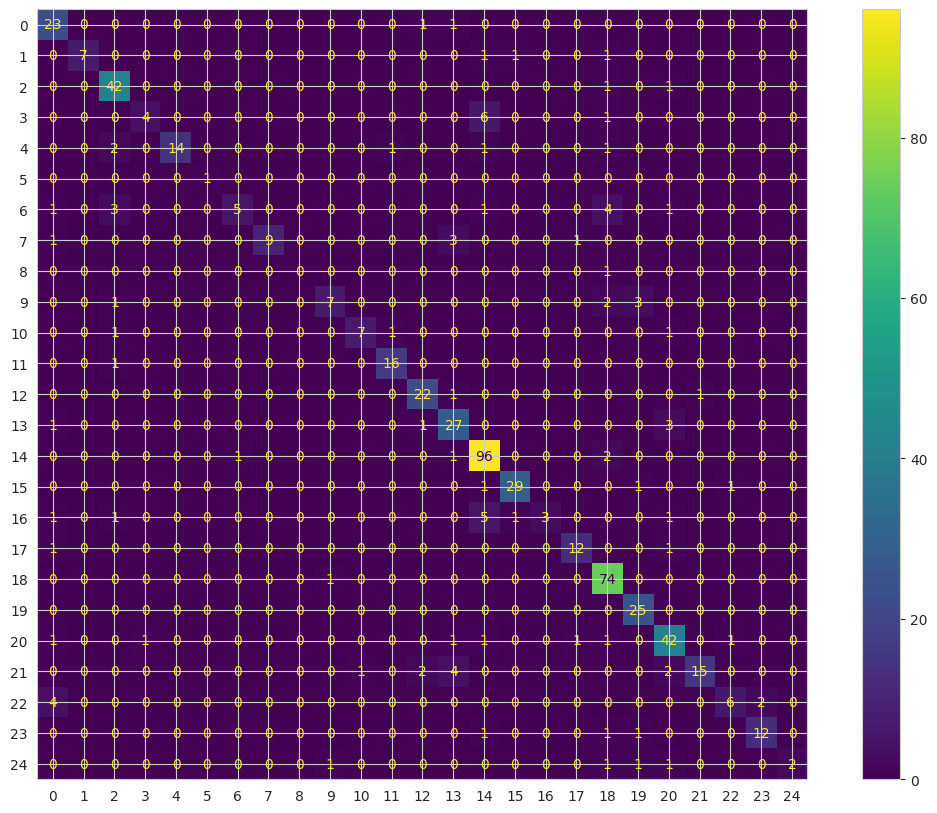

In [36]:
evaluate_model(et, X_train, y_train, X_test, y_test)

## Random Forest

In [38]:
rf_defaut = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

temps de calcul 0.24 s
accuracy = 0.8266666666666667


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

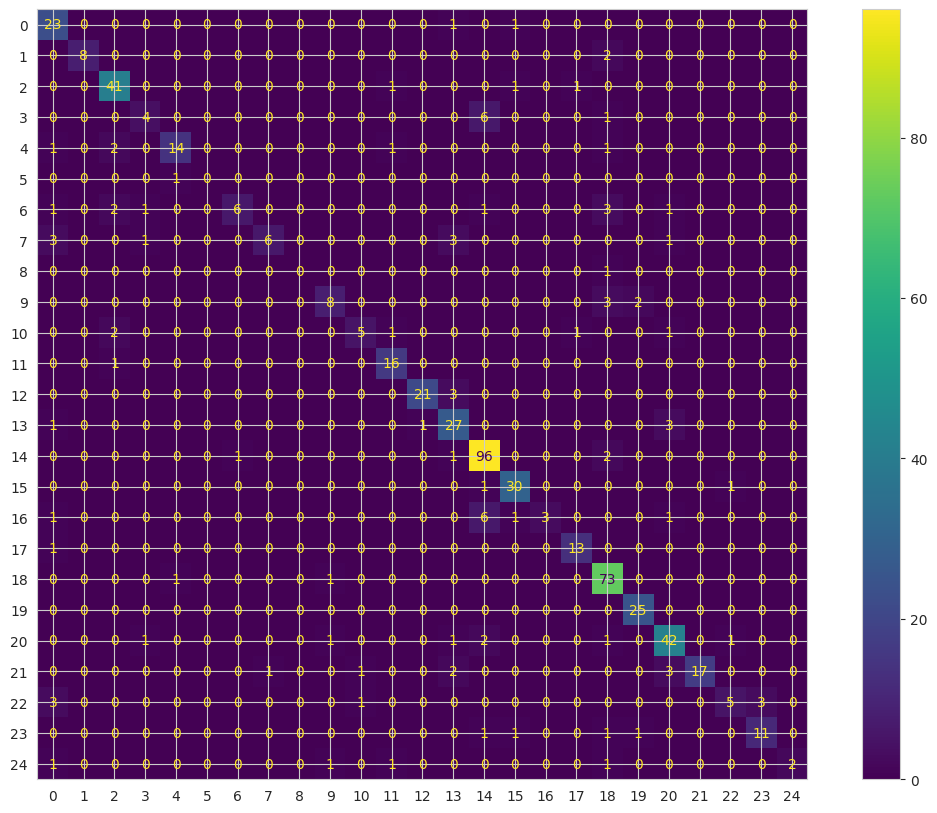

In [39]:
evaluate_model(rf_defaut, X_train, y_train, X_test, y_test)

# Grid search sur Hyper paramètres

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
rf_tuning = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [42]:
model_params = {
    "max_depth": [None, 5, 10],
    "n_estimators": [100, 50],
}

clf = GridSearchCV(
    estimator=rf_tuning,
    param_grid=model_params,
    scoring=make_scorer(accuracy_score),
    n_jobs=n_jobs,
    verbose=1,
    cv=kfold,
)

clf.fit(X_train, y_train)  # décommenter pour exécuter (peut durer des dizaines de minutes)
results = pd.DataFrame(clf.cv_results_)  # résultats détaillés de la CV
clf.best_estimator_  # notre meilleur modèle de RandomForest qu'on a obtenu

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


RandomForestClassifier(n_jobs=-2, random_state=0)

In [43]:
print("Voici les meilleurs paramètres")
print(f"{clf.best_estimator_.max_depth = },\n{clf.best_estimator_.n_estimators = }")

Voici les meilleurs paramètres
clf.best_estimator_.max_depth = None,
clf.best_estimator_.n_estimators = 100


temps de calcul 0.22 s
accuracy = 0.8266666666666667


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

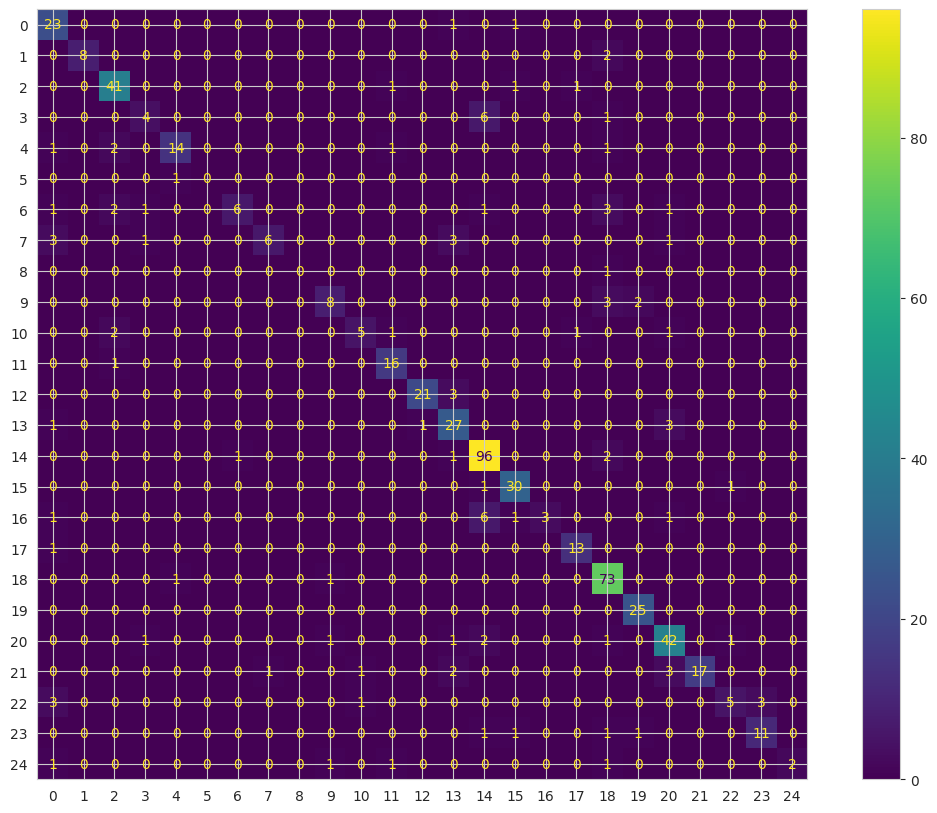

In [44]:
evaluate_model(clf.best_estimator_, X_train, y_train, X_test, y_test)